### Install and import necessary libraries


In [1]:
!pip install snntorch
!pip install tonic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 9.9 MB/s eta 0:00:00


In [2]:
import torch
import snntorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_per_process_memory_fraction(0.85, device=0)

import numpy as np

import tonic
from tonic import datasets, transforms
import torchvision as tv
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from collections import namedtuple

State = namedtuple("State", "obs labels")

### SHD2Raster: Tool for Rasterizing SHD (Spiking Neural Network) Samples into Frames

In [3]:
class _SHD2Raster():
    """
    Tool for rastering SHD samples into frames.
    This class is used to convert event-based data into a frame format suitable for use in neural networks.
    It packs bits along the temporal axis for memory efficiency, meaning the user will need to apply
    `jnp.unpackbits(events, axis=<time axis>)` prior to feeding the data into the network.
    """

    def __init__(self, encoding_dim, sample_T = 100):
        """
        Initializes the rasterizer with the desired encoding dimension and the sample duration.

        Args:
            encoding_dim (int): The number of possible spatial locations in the raster (i.e., width of the frame).
            sample_T (int, optional): The number of time steps to consider from the event stream. Defaults to 100.
        """
        self.encoding_dim = encoding_dim  # Set the encoding dimension (width of the frame)
        self.sample_T = sample_T  # Set the number of time steps to sample

    def __call__(self, events):
        """
        Converts event-based data into a rasterized tensor format for neural network input.

        Args:
            events (dict): A dictionary containing event-based data, which should include:
                - "t": Array of time steps for each event
                - "x": Array of spatial indices for each event

        Returns:
            numpy.ndarray: A binary tensor representing the rasterized events, shaped as [time_steps, encoding_dim].
        """

        # Initialize a zero matrix with shape (max_time_step+1, encoding_dim), to hold the event counts
        tensor = np.zeros((events["t"].max() + 1, self.encoding_dim), dtype=int)

        # Increment the corresponding positions in the tensor where events occurred (based on time 't' and spatial location 'x')
        np.add.at(tensor, (events["t"], events["x"]), 1)

        # Only keep the first 'sample_T' time steps
        tensor = tensor[:self.sample_T, :]

        # Set all values greater than 1 to 1, ensuring it's a binary representation
        tensor = np.minimum(tensor, 1)

        # Return the rasterized tensor
        return tensor


### Dowloading and Transforming SHD Dataset

In [4]:
# Define constants and parameters for processing
sample_T = 64                 # Number of timesteps to sample for the rasterized input
shd_timestep = 1e-6           # Time resolution of the SHD dataset in seconds (1 microsecond)
shd_channels = 700            # Number of spatial channels in the SHD dataset
net_channels = 128            # Number of spatial channels in the network
net_dt = 1 / sample_T         # Time step for the network (inverse of sample_T)
batch_size = 256              # Batch size for training and testing

# Define observation and action shapes for the network
obs_shape = tuple([net_channels,])  # Shape of the network's input (net_channels spatial dimension)
act_shape = tuple([20,])            # Shape of the network's output (e.g., 20 classes)

# Define transformations for the dataset
transform = transforms.Compose([
    # Downsample the data temporally and spatially to match the network's dimensions
    transforms.Downsample(
        time_factor=shd_timestep / net_dt,        # Factor to reduce the temporal resolution
        spatial_factor=net_channels / shd_channels  # Factor to reduce the spatial resolution
    ),
    # Convert SHD spike trains to rasterized input suitable for the network
    _SHD2Raster(net_channels, sample_T=sample_T)
])

# Load the SHD (Spiking Heidelberg Dataset) for training
train_dataset = datasets.SHD(
    "./data",              # Path to the dataset
    train=True,            # Load the training split
    transform=transform    # Apply the defined transformations
)

# Load the SHD dataset for testing
test_dataset = datasets.SHD(
    "./data",              # Path to the dataset
    train=False,           # Load the testing split
    transform=transform    # Apply the defined transformations
)


  0%|          | 0/130863613 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_train.h5.zip to ./data/SHD


  0%|          | 0/38141465 [00:00<?, ?it/s]

Extracting ./data/SHD/shd_test.h5.zip to ./data/SHD


### Preparing DataLoader for Training and Testing Datasets with Padded Tensors along with shuffle function for converting data into batches of 256

In [5]:
# Create a DataLoader to iterate through the training dataset
train_dl = iter(DataLoader(
    train_dataset,                                  # The SHD training dataset
    batch_size=len(train_dataset),                 # Set batch size to the full dataset size
    collate_fn=tonic.collation.PadTensors(         # Collate function to pad tensors for uniform dimensions
        batch_first=True                           # Ensure the batch dimension comes first
    ),
    drop_last=True,                                # Drop the last incomplete batch if dataset size is not divisible
    shuffle=False                                  # Do not shuffle the dataset
))

# Extract the first (and only) batch of data from the DataLoader
x_train, y_train = next(train_dl)                 # `x_train` contains input data, `y_train` contains labels

# Convert the data and labels to 8-bit unsigned integer tensors
x_train, y_train = x_train.to(torch.uint8), y_train.to(torch.uint8)

# Move the data and labels to the specified device (CPU or GPU)
x_train, y_train = x_train.to(device), y_train.to(device)


In [6]:
def shuffle(dataset):
    x, y = dataset

    cutoff = y.shape[0] % batch_size

    indices = torch.randperm(y.shape[0])[:-cutoff]
    obs, labels = x[indices], y[indices]


    obs = torch.reshape(obs, (-1, batch_size) + obs.shape[1:])
    labels = torch.reshape(labels, (-1, batch_size)) # should make batch size a global

    return State(obs=obs, labels=labels)

In [7]:
test_dl = iter(DataLoader(test_dataset, batch_size=len(test_dataset),
                          collate_fn=tonic.collation.PadTensors(batch_first=True), drop_last=True, shuffle=False))

x_test, y_test = next(test_dl)
x_test, y_test = x_test.to(torch.uint8), y_test.to(torch.uint8)
x_test, y_test = x_test.to(device), y_test.to(device)
x_test, y_test = shuffle((x_test, y_test))

In [8]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([8156, 64, 128])
torch.Size([8, 256, 64, 128])
torch.Size([8156])
torch.Size([8, 256])


### Adaptive Delay Scheduler Class



In [32]:
import torch

# Define number of hidden units and the maximum delay value
num_hidden = 64
max_delay = 50

class AdaptiveDelayScheduler:
    """
    A class to dynamically adjust the delay cap for neurons during training, based on their delay values
    and the fraction of neurons within a sliding window of delays.
    """

    def __init__(self, max_delay, cap_fraction=0.05, sliding_window=2):
        """
        Initializes the adaptive delay scheduler.

        Args:
        - max_delay (int): Maximum allowable delay cap (θ_d).
        - cap_fraction (float): Fraction of neurons within a sliding window (α_θ) to trigger delay cap adjustment.
        - sliding_window (int): Size of the sliding window (m) to consider for delay adjustment.
        """
        self.max_delay = max_delay  # Maximum allowable delay
        self.cap_fraction = cap_fraction  # Fraction of neurons within sliding window to trigger cap adjustment
        self.sliding_window = sliding_window  # Size of the sliding window used to calculate neuron distribution
        self.current_delay_cap = max_delay  # Initialize the current delay cap to the maximum value (θ_d)

    def adjust_delays(self, delays):
        """
        Adjusts the delays of neurons based on the sliding window and cap fraction criteria.

        Args:
        - delays (Tensor): A tensor representing the current delay values of neurons.

        Returns:
        - delays (Tensor): The adjusted delay values after considering the current delay cap and performance.
        """
        # Get the total number of neurons by flattening the delay tensor
        num_neurons = delays.numel()

        # Create a histogram of the delays, with bins equal to the max_delay value
        delay_histogram = torch.histc(delays, bins=self.max_delay, min=0, max=self.max_delay)

        # Define the range for the sliding window (α_θ), starting from (current_delay_cap - sliding_window) to current_delay_cap
        start_idx = max(0, self.current_delay_cap - self.sliding_window)

        # Sum the number of neurons within the sliding window range of delays
        sliding_window_sum = delay_histogram[start_idx:self.current_delay_cap + 1].sum()

        # Calculate α (the fraction of neurons within the sliding window) by dividing the window sum by the total number of neurons
        alpha = sliding_window_sum / num_neurons

        # If the fraction α exceeds the cap_fraction threshold, increase the delay cap (θ_d)
        if alpha > self.cap_fraction:
            self.current_delay_cap += 1  # Increment the delay cap
            self.counter = 0  # Reset counter (not used further in this code, might be used for other purposes)

        # Clamp (limit) the delay values to the current delay cap (θ_d)
        delays = torch.clamp(delays, max=self.current_delay_cap)

        # Return the adjusted delays
        return delays


# Initialize the scheduler with the maximum delay value
scheduler = AdaptiveDelayScheduler(max_delay)

### Network with 2 Hidden Layers and Delays

In [35]:
import torch.nn as nn
import snntorch as snn

class NetWithAdaptiveDelays(torch.nn.Module):
    """
    A neural network with adaptive delays for each neuron, utilizing spiking neurons and dynamic delay adjustment
    during training. This allows the network to adjust the temporal behavior of neurons dynamically based on
    the distribution of delays.
    """

    def __init__(self, num_hidden, max_delay):
        """
        Initialize the network with hidden layers and adaptive delay parameters for each neuron.

        Args:
        - num_hidden (int): Number of neurons in the hidden layers.
        - max_delay (int): Maximum allowable delay for each neuron.
        """
        super().__init__()

        # Define the layers of the network
        self.fc1 = torch.nn.Linear(128, num_hidden)  # First fully connected layer
        self.lif1 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True)  # First LIF (Leaky Integrate and Fire) neuron layer
        self.fc2 = torch.nn.Linear(num_hidden, num_hidden)  # Second fully connected layer
        self.lif2 = snntorch.Leaky(beta=torch.ones(num_hidden) * 0.5, learn_beta=True)  # Second LIF layer
        self.fc3 = torch.nn.Linear(num_hidden, 20)  # Output layer
        self.lif3 = snntorch.Leaky(beta=torch.ones(20) * 0.5, learn_beta=True, reset_mechanism="none")  # Output LIF layer

        # Define delay parameters for hidden and output layers (learnable parameters)
        self.hidden_delays = nn.Parameter(torch.randint(0, max_delay, (num_hidden,), dtype=torch.float32))  # Delay for hidden neurons
        self.output_delays = nn.Parameter(torch.randint(0, max_delay, (20,), dtype=torch.float32))  # Delay for output neurons

    def apply_delays_to_sequence(self, spike_train, delays):
        """
        Applies delays to a spike train sequence for each neuron.

        Args:
        - spike_train (Tensor): A tensor of shape [time, batch, neurons] representing the spike train.
        - delays (Tensor): A tensor containing the delay for each neuron.

        Returns:
        - delayed_spike_train (Tensor): A tensor with the delays applied to each neuron's spike train.
        """
        time_steps, batch_size, num_neurons = spike_train.shape
        delayed_spike_train = torch.zeros_like(spike_train)  # Initialize the tensor for delayed spikes

        # Loop over each neuron and apply its respective delay
        for neuron_idx, delay in enumerate(delays):
            delay = int(delay.item())  # Convert the delay to an integer
            if delay > 0:
                # If delay is greater than zero, shift the spikes forward in time
                delayed_spike_train[delay:, :, neuron_idx] = spike_train[:-delay, :, neuron_idx]
            else:
                # If no delay, keep the spikes unchanged
                delayed_spike_train[:, :, neuron_idx] = spike_train[:, :, neuron_idx]

        return delayed_spike_train

    def forward(self, x):
        """
        Defines the forward pass of the network. This applies delays to the spike trains, computes the membrane
        potential, and generates the final output spikes for each neuron.

        Args:
        - x (Tensor): The input tensor of shape [batch, time, channel].

        Returns:
        - (Tensor): The output spikes of the network after applying delays and passing through the layers.
        """
        x = x.float()  # Ensure input is of float type
        x = x.permute(1, 0, 2)  # Reshape input to [time, batch, channel]

        # Initialize the membrane potentials for the LIF neurons at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        V = []  # To store the final output spikes
        spike_train1 = []  # To collect spikes for the first layer over time

        # Iterate over the time steps of the input sequence
        for t, step in enumerate(x):
            # First layer processing: Compute current input and spike train for first LIF layer
            cur1 = self.fc1(step)  # Linear transformation
            spk1, mem1 = self.lif1(cur1, mem1)  # LIF neuron dynamics: spiking and updating membrane potential

            # Collect spikes from the first layer for delay processing
            spike_train1.append(spk1)

        # Convert spike train list into a tensor with shape [time, batch, neurons]
        spike_train1 = torch.stack(spike_train1, dim=0)

        # Apply delays to the spike train
        spk1_delayed = self.apply_delays_to_sequence(spike_train1, self.hidden_delays)

        # Process delayed spike trains through subsequent layers
        for t in range(spk1_delayed.size(0)):
            cur2 = self.fc2(spk1_delayed[t])  # Second layer processing
            spk2, mem2 = self.lif2(cur2, mem2)  # LIF dynamics for second layer
            cur3 = self.fc3(spk2)  # Output layer processing
            spk3, mem3 = self.lif3(cur3, mem3)  # LIF dynamics for output layer
            V.append(mem3)  # Collect the output spike for each time step

        # Return the stacked output spikes [batch, time, neurons]
        return torch.stack(V, axis=0).permute(1, 0, 2)

    def update_delays(self, scheduler):
        """
        Updates the delay values for hidden layer using the AdaptiveDelayScheduler.

        Args:
        - scheduler (AdaptiveDelayScheduler): An instance of the scheduler that adjusts the delays based on performance.
        """
        # Update the delay values for hidden layer using the scheduler
        self.hidden_delays.data = scheduler.adjust_delays(self.hidden_delays)

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = NetWithAdaptiveDelays(num_hidden, max_delay).to(device)

### Total Parameters

In [39]:
total_params = sum(p.numel() for p in net.parameters())

print(f"Total Parameters in the Network: {total_params}")

Total Parameters in the Network: 13948


### Loss, Optimizer and Accuracy

In [37]:
# Cross Entropy Loss with label smoothing
loss = torch.nn.CrossEntropyLoss(label_smoothing=0.3)

# Optimizer: Adam optimizer for training the model
# This optimizer is adaptive, adjusting learning rates based on past gradients.
optimizer = torch.optim.Adam(net.parameters(), lr=5e-4)

# Accuracy calculation function
# This lambda function computes the accuracy by comparing the predicted class
acc = lambda predictions, targets : (torch.argmax(predictions, axis=-1) == targets).sum().item() / len(targets)

### Training and Testing Loop with Graphs

Training Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: Training Loss = 12.7055, Training Accuracy = 4.98%


Training Epochs:   2%|▏         | 1/50 [00:07<06:06,  7.48s/it]

Epoch 1: Test Loss = 10.9010, Test Accuracy = 4.88%
Epoch 2: Training Loss = 8.7841, Training Accuracy = 2.68%


Training Epochs:   4%|▍         | 2/50 [00:14<05:44,  7.18s/it]

Epoch 2: Test Loss = 5.6423, Test Accuracy = 0.68%
Epoch 3: Training Loss = 4.5058, Training Accuracy = 4.30%


Training Epochs:   6%|▌         | 3/50 [00:21<05:41,  7.26s/it]

Epoch 3: Test Loss = 3.7290, Test Accuracy = 7.32%
Epoch 4: Training Loss = 3.4214, Training Accuracy = 6.14%


Training Epochs:   8%|▊         | 4/50 [00:28<05:22,  7.02s/it]

Epoch 4: Test Loss = 3.3380, Test Accuracy = 8.40%
Epoch 5: Training Loss = 3.2338, Training Accuracy = 7.36%


Training Epochs:  10%|█         | 5/50 [00:35<05:19,  7.10s/it]

Epoch 5: Test Loss = 3.1538, Test Accuracy = 10.21%
Epoch 6: Training Loss = 3.0685, Training Accuracy = 11.25%


Training Epochs:  12%|█▏        | 6/50 [00:42<05:14,  7.15s/it]

Epoch 6: Test Loss = 2.9799, Test Accuracy = 13.72%
Epoch 7: Training Loss = 2.9154, Training Accuracy = 15.40%


Training Epochs:  14%|█▍        | 7/50 [00:49<05:03,  7.05s/it]

Epoch 7: Test Loss = 2.8021, Test Accuracy = 19.29%
Epoch 8: Training Loss = 2.7717, Training Accuracy = 21.13%


Training Epochs:  16%|█▌        | 8/50 [00:57<05:04,  7.25s/it]

Epoch 8: Test Loss = 2.6488, Test Accuracy = 27.25%
Epoch 9: Training Loss = 2.6611, Training Accuracy = 27.02%


Training Epochs:  18%|█▊        | 9/50 [01:04<04:56,  7.23s/it]

Epoch 9: Test Loss = 2.5481, Test Accuracy = 34.47%
Epoch 10: Training Loss = 2.5758, Training Accuracy = 32.51%


Training Epochs:  20%|██        | 10/50 [01:11<04:50,  7.26s/it]

Epoch 10: Test Loss = 2.4784, Test Accuracy = 38.53%
Epoch 11: Training Loss = 2.5310, Training Accuracy = 35.36%


Training Epochs:  22%|██▏       | 11/50 [01:18<04:35,  7.07s/it]

Epoch 11: Test Loss = 2.4395, Test Accuracy = 41.99%
Epoch 12: Training Loss = 2.4887, Training Accuracy = 38.38%


Training Epochs:  24%|██▍       | 12/50 [01:25<04:30,  7.11s/it]

Epoch 12: Test Loss = 2.4037, Test Accuracy = 45.31%
Epoch 13: Training Loss = 2.4496, Training Accuracy = 41.67%


Training Epochs:  26%|██▌       | 13/50 [01:33<04:25,  7.17s/it]

Epoch 13: Test Loss = 2.3606, Test Accuracy = 46.19%
Epoch 14: Training Loss = 2.4174, Training Accuracy = 44.37%


Training Epochs:  28%|██▊       | 14/50 [01:39<04:13,  7.04s/it]

Epoch 14: Test Loss = 2.3107, Test Accuracy = 50.73%
Epoch 15: Training Loss = 2.3763, Training Accuracy = 47.32%


Training Epochs:  30%|███       | 15/50 [01:47<04:09,  7.12s/it]

Epoch 15: Test Loss = 2.2674, Test Accuracy = 55.08%
Epoch 16: Training Loss = 2.3349, Training Accuracy = 51.06%


Training Epochs:  32%|███▏      | 16/50 [01:53<03:56,  6.96s/it]

Epoch 16: Test Loss = 2.2383, Test Accuracy = 56.98%
Epoch 17: Training Loss = 2.2928, Training Accuracy = 54.32%


Training Epochs:  34%|███▍      | 17/50 [02:01<03:52,  7.06s/it]

Epoch 17: Test Loss = 2.2323, Test Accuracy = 58.25%
Epoch 18: Training Loss = 2.2691, Training Accuracy = 56.07%


Training Epochs:  36%|███▌      | 18/50 [02:07<03:40,  6.90s/it]

Epoch 18: Test Loss = 2.2013, Test Accuracy = 62.70%
Epoch 19: Training Loss = 2.2400, Training Accuracy = 58.53%


Training Epochs:  38%|███▊      | 19/50 [02:14<03:38,  7.04s/it]

Epoch 19: Test Loss = 2.1765, Test Accuracy = 63.82%
Epoch 20: Training Loss = 2.2213, Training Accuracy = 59.92%


Training Epochs:  40%|████      | 20/50 [02:21<03:29,  6.97s/it]

Epoch 20: Test Loss = 2.1539, Test Accuracy = 64.99%
Epoch 21: Training Loss = 2.1935, Training Accuracy = 62.92%


Training Epochs:  42%|████▏     | 21/50 [02:28<03:22,  7.00s/it]

Epoch 21: Test Loss = 2.1544, Test Accuracy = 65.04%
Epoch 22: Training Loss = 2.1763, Training Accuracy = 64.00%


Training Epochs:  44%|████▍     | 22/50 [02:36<03:17,  7.06s/it]

Epoch 22: Test Loss = 2.1478, Test Accuracy = 64.36%
Epoch 23: Training Loss = 2.1648, Training Accuracy = 64.48%


Training Epochs:  46%|████▌     | 23/50 [02:42<03:07,  6.94s/it]

Epoch 23: Test Loss = 2.1394, Test Accuracy = 66.60%
Epoch 24: Training Loss = 2.1454, Training Accuracy = 66.05%


Training Epochs:  48%|████▊     | 24/50 [02:49<03:03,  7.05s/it]

Epoch 24: Test Loss = 2.1209, Test Accuracy = 67.33%
Epoch 25: Training Loss = 2.1338, Training Accuracy = 67.26%


Training Epochs:  50%|█████     | 25/50 [02:56<02:52,  6.91s/it]

Epoch 25: Test Loss = 2.1101, Test Accuracy = 68.36%
Epoch 26: Training Loss = 2.1172, Training Accuracy = 68.79%


Training Epochs:  52%|█████▏    | 26/50 [03:03<02:48,  7.03s/it]

Epoch 26: Test Loss = 2.0985, Test Accuracy = 68.26%
Epoch 27: Training Loss = 2.1132, Training Accuracy = 68.13%


Training Epochs:  54%|█████▍    | 27/50 [03:10<02:38,  6.90s/it]

Epoch 27: Test Loss = 2.1168, Test Accuracy = 67.53%
Epoch 28: Training Loss = 2.0970, Training Accuracy = 69.34%


Training Epochs:  56%|█████▌    | 28/50 [03:17<02:33,  7.00s/it]

Epoch 28: Test Loss = 2.0917, Test Accuracy = 69.24%
Epoch 29: Training Loss = 2.0890, Training Accuracy = 70.14%


Training Epochs:  58%|█████▊    | 29/50 [03:24<02:28,  7.05s/it]

Epoch 29: Test Loss = 2.1127, Test Accuracy = 66.80%
Epoch 30: Training Loss = 2.0826, Training Accuracy = 70.06%


Training Epochs:  60%|██████    | 30/50 [03:31<02:19,  6.95s/it]

Epoch 30: Test Loss = 2.1055, Test Accuracy = 67.97%
Epoch 31: Training Loss = 2.0778, Training Accuracy = 70.58%


Training Epochs:  62%|██████▏   | 31/50 [03:38<02:14,  7.08s/it]

Epoch 31: Test Loss = 2.1048, Test Accuracy = 69.19%
Epoch 32: Training Loss = 2.0629, Training Accuracy = 71.91%


Training Epochs:  64%|██████▍   | 32/50 [03:45<02:04,  6.92s/it]

Epoch 32: Test Loss = 2.0849, Test Accuracy = 70.51%
Epoch 33: Training Loss = 2.0618, Training Accuracy = 71.51%


Training Epochs:  66%|██████▌   | 33/50 [03:52<01:59,  7.03s/it]

Epoch 33: Test Loss = 2.0888, Test Accuracy = 69.82%
Epoch 34: Training Loss = 2.0489, Training Accuracy = 72.39%


Training Epochs:  68%|██████▊   | 34/50 [03:59<01:50,  6.90s/it]

Epoch 34: Test Loss = 2.0748, Test Accuracy = 70.17%
Epoch 35: Training Loss = 2.0489, Training Accuracy = 72.28%


Training Epochs:  70%|███████   | 35/50 [04:06<01:45,  7.02s/it]

Epoch 35: Test Loss = 2.0745, Test Accuracy = 70.95%
Epoch 36: Training Loss = 2.0414, Training Accuracy = 72.92%


Training Epochs:  72%|███████▏  | 36/50 [04:13<01:36,  6.92s/it]

Epoch 36: Test Loss = 2.0969, Test Accuracy = 69.68%
Epoch 37: Training Loss = 2.0317, Training Accuracy = 74.21%


Training Epochs:  74%|███████▍  | 37/50 [04:20<01:31,  7.01s/it]

Epoch 37: Test Loss = 2.0804, Test Accuracy = 69.78%
Epoch 38: Training Loss = 2.0338, Training Accuracy = 73.55%


Training Epochs:  76%|███████▌  | 38/50 [04:28<01:25,  7.16s/it]

Epoch 38: Test Loss = 2.0962, Test Accuracy = 69.48%
Epoch 39: Training Loss = 2.0298, Training Accuracy = 73.79%


Training Epochs:  78%|███████▊  | 39/50 [04:34<01:16,  6.99s/it]

Epoch 39: Test Loss = 2.0989, Test Accuracy = 69.09%
Epoch 40: Training Loss = 2.0240, Training Accuracy = 74.81%


Training Epochs:  80%|████████  | 40/50 [04:42<01:11,  7.11s/it]

Epoch 40: Test Loss = 2.0614, Test Accuracy = 72.12%
Epoch 41: Training Loss = 2.0192, Training Accuracy = 74.72%


Training Epochs:  82%|████████▏ | 41/50 [04:48<01:02,  6.95s/it]

Epoch 41: Test Loss = 2.0800, Test Accuracy = 70.61%
Epoch 42: Training Loss = 2.0100, Training Accuracy = 75.15%


Training Epochs:  84%|████████▍ | 42/50 [04:55<00:56,  7.06s/it]

Epoch 42: Test Loss = 2.0687, Test Accuracy = 71.63%
Epoch 43: Training Loss = 2.0052, Training Accuracy = 75.60%


Training Epochs:  86%|████████▌ | 43/50 [05:02<00:48,  6.93s/it]

Epoch 43: Test Loss = 2.0601, Test Accuracy = 71.92%
Epoch 44: Training Loss = 2.0010, Training Accuracy = 75.50%


Training Epochs:  88%|████████▊ | 44/50 [05:09<00:42,  7.05s/it]

Epoch 44: Test Loss = 2.0676, Test Accuracy = 72.12%
Epoch 45: Training Loss = 2.0032, Training Accuracy = 75.18%


Training Epochs:  90%|█████████ | 45/50 [05:16<00:35,  7.04s/it]

Epoch 45: Test Loss = 2.0343, Test Accuracy = 73.49%
Epoch 46: Training Loss = 1.9986, Training Accuracy = 75.58%


Training Epochs:  92%|█████████▏| 46/50 [05:23<00:27,  6.95s/it]

Epoch 46: Test Loss = 2.0372, Test Accuracy = 73.73%
Epoch 47: Training Loss = 1.9927, Training Accuracy = 75.71%


Training Epochs:  94%|█████████▍| 47/50 [05:30<00:21,  7.04s/it]

Epoch 47: Test Loss = 2.0384, Test Accuracy = 73.58%
Epoch 48: Training Loss = 1.9816, Training Accuracy = 76.54%


Training Epochs:  96%|█████████▌| 48/50 [05:37<00:13,  6.91s/it]

Epoch 48: Test Loss = 2.0273, Test Accuracy = 73.73%
Epoch 49: Training Loss = 1.9812, Training Accuracy = 76.86%


Training Epochs:  98%|█████████▊| 49/50 [05:44<00:07,  7.04s/it]

Epoch 49: Test Loss = 2.0507, Test Accuracy = 72.56%
Epoch 50: Training Loss = 1.9680, Training Accuracy = 77.82%


Training Epochs: 100%|██████████| 50/50 [05:51<00:00,  7.03s/it]

Epoch 50: Test Loss = 2.0416, Test Accuracy = 72.80%


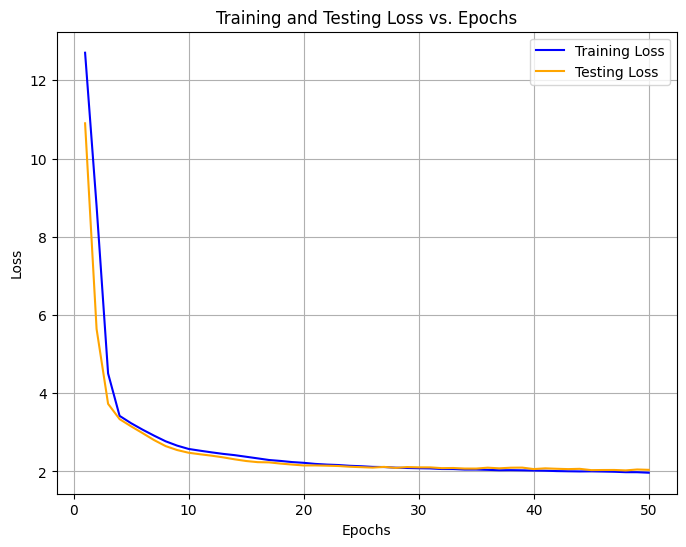

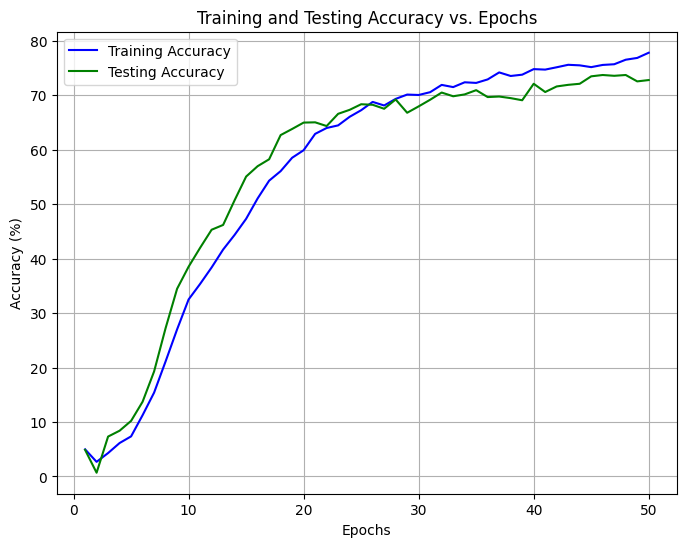

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm

num_epochs = 50  # Example number of epochs
loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# Outer training loop
for epoch in tqdm.tqdm(range(num_epochs), desc="Training Epochs"):
    # Shuffle and prepare training batch
    train_batch = shuffle((x_train, y_train))
    train_data, train_targets = train_batch

    epoch_loss = 0  # To track average loss for the epoch
    batch_train_acc = []  # To track accuracy for the training set in this epoch

    # Minibatch training loop
    for data, targets in zip(train_data, train_targets):
        # Forward pass
        net.train()
        out_V = net(data)
        # Initialize the loss & sum over time
        loss_val = loss(torch.sum(out_V, axis=-2), targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss_val.item()

        # Calculate training accuracy
        batch_train_acc.append(acc(torch.sum(out_V, axis=-2), targets))


    #Update the delays in the net with Adpative Scheduler
    net.update_delays(scheduler)
    # Compute average loss and accuracy for the epoch
    avg_epoch_loss = epoch_loss / len(train_data)
    avg_train_acc = np.mean(batch_train_acc) * 100  # Convert accuracy to percentage

    loss_hist.append(avg_epoch_loss)
    train_acc_hist.append(avg_train_acc)

    print(f"Epoch {epoch+1}: Training Loss = {avg_epoch_loss:.4f}, Training Accuracy = {avg_train_acc:.2f}%")

    # Test set evaluation at the end of each epoch
    with torch.no_grad():
        batch_test_acc = []
        batch_test_loss = []

        for test_data, test_targets in zip(x_test, y_test):
            net.eval()
            # Test set forward pass
            out_V = net(test_data)
            # Calculate accuracy and loss
            batch_test_acc.append(acc(torch.sum(out_V, axis=-2), test_targets))
            test_loss = loss(torch.sum(out_V, axis=-2), test_targets).item()
            batch_test_loss.append(test_loss)


        # Average test accuracy and test loss for the epoch
        avg_test_acc = np.mean(batch_test_acc) * 100  # Convert accuracy to percentage
        avg_test_loss = np.mean(batch_test_loss)

        test_loss_hist.append(avg_test_loss)
        test_acc_hist.append(avg_test_acc)

        print(f"Epoch {epoch+1}: Test Loss = {avg_test_loss:.4f}, Test Accuracy = {avg_test_acc:.2f}%")

# Plotting graphs
epochs = np.arange(1, num_epochs + 1)

# Plot Training and Testing Loss
plt.figure(figsize=(8, 6))
plt.plot(epochs, loss_hist, label="Training Loss", color="blue")
plt.plot(epochs, test_loss_hist, label="Testing Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Testing Accuracy
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_acc_hist, label="Training Accuracy", color="blue")
plt.plot(epochs, test_acc_hist, label="Testing Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Testing Accuracy vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()
